In [1]:
! pip install python-dotenv
! pip install pymorphy2 nltk scikit-learn
! pip install catboost
! pip install xgboost
! pip install -U scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 2.0 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.4.2
    Uninstalling scikit-learn-1.4.2:
      Successfully uninstalled scikit-learn-1.4.2


In [2]:
import pandas as pd
import numpy as np

import gdown
import os
import json

from dotenv import load_dotenv

import pymorphy2
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk

nltk.download('punkt')
nltk.download('stopwords')

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package punkt to /home/kitsu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/kitsu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
ROOT_DIR: str = os.path.dirname(os.path.abspath(os.curdir))
DATASET_PATH: str = f"{ROOT_DIR}/source_data/superset_hr.xlsx"
SKILLS_JSON_PATH: str = f"{ROOT_DIR}/source_data/skills_dictionary.json"
GOOGLE_COLAB_PATH: str = '/content/superset_hr.xlsx'

load_dotenv()
SKILL_DICT_URL = os.environ.get('SKILL_DICT_URL')
DATASET_URL = os.environ.get('DATASET_URL')

if DATASET_URL is None:
    print('>>> .env was not found!', end='\n\n')
    DATASET_URL = input('>>> Provide DATASET url for downloading: ')

    if SKILL_DICT_URL is None:
        SKILL_DICT_URL = input('>>> Provide JSON url for downloading: ')

In [4]:
def get_skill_dict() -> dict[str: list[int]]:
    try:
        with open(file=SKILLS_JSON_PATH, mode='r') as input_json_file:
            data = json.load(input_json_file)
    except FileNotFoundError:
        print(f"Can't open file from path: {SKILLS_JSON_PATH}", end='\n\n')
        file_name = gdown.download(SKILL_DICT_URL, fuzzy=True)
        os.makedirs(os.path.dirname(SKILLS_JSON_PATH), exist_ok=True)
        os.rename(os.path.abspath(file_name), SKILLS_JSON_PATH)
        print(f'Moved to: {SKILLS_JSON_PATH}', end='\n\n')
        
        with open(file=SKILLS_JSON_PATH, mode='r') as input_json_file:
            data = json.load(input_json_file)
    return data

def get_original_dataframe() -> pd.DataFrame:
    try:
        df = pd.read_excel(DATASET_PATH)
    except FileNotFoundError:
        try:
            print(f"Can't open file from path: {DATASET_PATH}", end='\n\n')
            df = pd.read_excel(GOOGLE_COLAB_PATH)
        except FileNotFoundError:
            print(f"Can't open file from path: {GOOGLE_COLAB_PATH}", end='\n\n')
            file_name = gdown.download(DATASET_URL, fuzzy=True)
            os.makedirs(os.path.dirname(DATASET_PATH), exist_ok=True)
            os.rename(os.path.abspath(file_name), DATASET_PATH)
            print(f'Moved to: {DATASET_PATH}', end='\n\n')
            df = pd.read_excel(DATASET_PATH)
    finally:
        print('Success!')
        return df

In [5]:
skills_dict = get_skill_dict()

In [6]:
df_original = get_original_dataframe()

Success!


In [7]:
print(df_original.shape)
df_original.sample(3)

(188833, 21)


,id,income_name,name,published_at,created_at,collected_at,url,area__name,salary__currency,salary__gross,...,address__city,schedule__name,grade,employment__name,key_skills__names,languages__names,exchange_rate,salary_from_gross,salary_to_gross,salary_average
177467,102555614,Веб дизайнер,Web-дизайнер,2024-06-24T08:37:31+0300,2024-06-24T08:37:31+0300,2024-06-27 03:07:49.680,https://api.hh.ru/vacancies/102555614?host=hh.ru,Пермь,RUR,0.0,...,Пермь,Полный день,Junior (1-3),Полная занятость,[],[],1.0,62150.0,NaN,NaN
164079,101722400,Аналитик,Бизнес-аналитик,2024-06-11T11:22:52+0300,2024-06-11T11:22:52+0300,2024-06-27 03:07:49.680,https://api.hh.ru/vacancies/101722400?host=hh.ru,Тула,RUR,0.0,...,NaN,Полный день,Junior (1-3),Полная занятость,[],[],1.0,56500.0,NaN,NaN
128768,96996455,Специалист технической поддержки,Специалист технической поддержки,2024-04-15T11:35:22+0300,2024-04-15T11:35:22+0300,2024-04-17 10:50:23.602,https://api.hh.ru/vacancies/96996455?host=hh.ru,Москва,RUR,0.0,...,Москва,Полный день,Junior (1-3),Полная занятость,[],[],1.0,146900.0,NaN,NaN


In [14]:
def print_df_info(df: pd.DataFrame) -> None:
    print(f"Shape: {df.shape}")
    print('-' * 50)
    display(df.sample(3))
    print('-' * 50)
    display(df.info())
    print('-' * 50)
    display(df.isna().sum())
    print('-' * 50)


def get_clear_df_version(df: pd.DataFrame) -> pd.DataFrame:
    df_new = df[['income_name', 'area__name', 'schedule__name', 'grade',
                 'key_skills__names', 'salary__currency',
                 'exchange_rate', 'salary_from_gross', 'salary_to_gross', 'salary_average']].copy()

    df_new = df_new.dropna(subset=['salary_from_gross', 'salary_to_gross', 'salary_average'], how='all')
    df_new = df_new.dropna(subset=['income_name'])

    selected_cities = {'Москва', 'Санкт-Петербург', 'Новосибирск', 'Екатеринбург', 'Казань'}

    def replace_city(city):
        if city in selected_cities:
            return city
        else:
            return 'Другой'

    df_new['area__name'] = df_new['area__name'].apply(replace_city)
    df_new['not_rur'] = df_new['exchange_rate'] != 1
    df_new['not_rur'] = df_new['not_rur'].astype(int)
    df_new = df_new.drop(['salary__currency', 'exchange_rate'], axis=1)

    return df_new


def get_difference_percentiles(df: pd.DataFrame) -> tuple[float, float, float]:
    filtered_df = df.dropna(subset=['salary_from_gross', 'salary_to_gross']).copy()
    filtered_df.loc[:, 'difference'] = filtered_df['salary_to_gross'] - filtered_df['salary_from_gross']
    condition = filtered_df['difference'] > 0.8 * filtered_df['salary_to_gross']
    filtered_df.loc[condition, ['salary_from_gross', 'difference']] = np.nan

    filtered_df = filtered_df.dropna(subset=['salary_from_gross', 'salary_to_gross'])

    filtered_df = filtered_df[filtered_df['salary_from_gross'] >= 1000]
    filtered_df = filtered_df[filtered_df['salary_to_gross'] >= 10000]

    filtered_df.loc[:, 'difference_ratio'] = np.where(filtered_df['salary_to_gross'] != 0, 
                                                      filtered_df['difference'] / filtered_df['salary_to_gross'], 
                                                      np.nan)

    perc25 = filtered_df['difference_ratio'].quantile(0.25)
    perc50 = filtered_df['difference_ratio'].quantile(0.50)
    perc75 = filtered_df['difference_ratio'].quantile(0.75)

    return perc25, perc50, perc75


def fill_na_salary(df: pd.DataFrame, coef) -> pd.DataFrame:
    result_df = df.copy()
    result_df['salary_to_gross'] = result_df['salary_to_gross'].fillna(result_df['salary_from_gross'] / (1-coef))
    result_df['salary_from_gross'] = result_df['salary_from_gross'].fillna(result_df['salary_to_gross'] * (1-coef))
    result_df['salary_average'] = result_df['salary_average'].fillna((result_df['salary_to_gross'] + result_df['salary_from_gross']) / 2)
    
    result_df[['salary_to_gross', 'salary_from_gross', 'salary_average']] = result_df[['salary_to_gross', 'salary_from_gross', 'salary_average']].astype(float)
    return result_df


def exctract_features(df: pd.DataFrame) -> pd.DataFrame:
    transformers = [
        ('schedule_name', OneHotEncoder(sparse_output=False, drop='first'), ['schedule__name']),
        ('grade', OneHotEncoder(sparse_output=False, drop='first'), ['grade']),
        ('income_name', OneHotEncoder(sparse_output=False, drop='first'), ['income_name']),
        ('area_name', OneHotEncoder(sparse_output=False, drop='first'), ['area__name'])
    ]

    pipeline = Pipeline(steps=[
        ('column_transformer', ColumnTransformer(transformers=transformers, remainder='passthrough'))
    ])

    display(pipeline)

    df_transformed = pipeline.fit_transform(df)
    column_names = pipeline.named_steps['column_transformer'].get_feature_names_out()
    transofrmed_cols = [x for x in column_names if 'remainder' not in x]
    column_names = [x.replace('remainder__', '') if x not in transofrmed_cols else x for x in column_names]
    
    df_new = pd.DataFrame(df_transformed, columns=column_names)
    df_new[transofrmed_cols] = df_new[transofrmed_cols].astype(float)
    
    return df_new


def convert_skills(skill_string: str, skills_dict: dict) -> tuple[list[str], int, list[str]]:
    try:
        skill_list = eval(skill_string)
        if not isinstance(skill_list, list):
            return np.nan, 0, []
    except:
        return np.nan, 0, []

    converted_skills = []
    unconverted_skills = []

    for skill in skill_list:
        found = False
        for main_skill, variations in skills_dict.items():
            if skill in variations:
                converted_skills.append(main_skill)
                found = True
                break
        if not found:
            unconverted_skills.append(skill)

    return converted_skills, unconverted_skills


def preprocess_key_skills(df: pd.DataFrame, s_dict: dict[str: list[str]]) -> pd.DataFrame:
    df_new = df.copy()
    df_new[['skills', 'unconverted_skills']] = df_new['key_skills__names'].apply(
    lambda x: pd.Series(convert_skills(x, s_dict)))
    df_new = df_new.drop(['key_skills__names'], axis=1)

    return df_new


morph = pymorphy2.MorphAnalyzer()
nltk_stop_words  = set(stopwords.words('russian'))
custom_words = {',', ':', 'работа', 'активный', 'язык', 'навык', 'деловой', 'ведение', 'проведение', 'презентация', 'грамотный'}
stop_words = nltk_stop_words.union(custom_words)


def tokenize_and_lemmatize(skill_list: list[str]) -> list[str]:
    tokens = []
    for skill in skill_list:
        words = word_tokenize(skill)
        lemmas = [morph.parse(word.lower())[0].normal_form for word in words if word.lower() not in stop_words]
        tokens.extend(lemmas)
    return tokens


def process_skills(df: pd.DataFrame, freq_cutoff: int = 100, add_unprocessed = False) -> pd.DataFrame:
    df_processed = df.copy()
    df_processed['unskills_processed'] = df_processed['unconverted_skills'].apply(tokenize_and_lemmatize)
    df_processed['skills_processed'] = df_processed['skills'].apply(tokenize_and_lemmatize)

    unskills_counts = df_processed['unskills_processed'].explode().value_counts()
    frequent_unskills = unskills_counts[unskills_counts >= freq_cutoff].index
    df_processed['unskills_filtered'] = df_processed['unskills_processed'].apply(lambda skills: [skill for skill in skills if skill in frequent_unskills])

    skills_counts = df_processed['skills_processed'].explode().value_counts()
    frequent_skills = skills_counts[skills_counts >= freq_cutoff].index
    df_processed['skills_filtered'] = df_processed['skills_processed'].apply(lambda skills: [skill for skill in skills if skill in frequent_skills])

    if add_unprocessed:
        df_processed['skills_plus'] = df_processed['skills_filtered'] + df_processed['unskills_filtered']
    else:
        df_processed['skills_plus'] = df_processed['skills_filtered']

    df_processed = df_processed[df_processed['skills_plus'].apply(lambda x: len(x) > 0)]

    df_processed = df_processed.drop(['unconverted_skills',
                                      'skills',
                                      'unskills_processed',
                                      'unskills_filtered',
                                      'skills_filtered',
                                      'skills_processed',
                                      'not_rur'
                                      ], axis = 1)
    return df_processed


def vectorize_PCA_skills(df: pd.DataFrame, n_components: int = 100, PCA_enable: bool = True) -> pd.DataFrame:
    df_vect = df.copy()
    df_vect['skills_plus'] = df_vect['skills_plus'].apply(lambda x: ' '.join(x))

    vectorizer = TfidfVectorizer()
    display(vectorizer)
    skills_tfidf = vectorizer.fit_transform(df_vect['skills_plus'])
    skills_df = pd.DataFrame(skills_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
    df_vect = df_vect.reset_index()
    
    if PCA_enable:
        pca = PCA(n_components=n_components)
        skills_pca = pca.fit_transform(skills_df)
        skills_pca_df = pd.DataFrame(skills_pca, columns=[f'component_{i+1}' for i in range(skills_pca.shape[1])])        
        df_merged = pd.concat([df_vect, skills_pca_df], axis=1)
        display(PCA)
    else:
        df_merged = pd.concat([df_vect, skills_df], axis=1)

    df_merged = df_merged.drop(['skills_plus', 'index'], axis=1)
    df_merged[[
               'salary_from_gross',
               'salary_to_gross',
               'salary_average']] = df_merged[[
                                               'salary_from_gross',
                                               'salary_to_gross',
                                               'salary_average']].astype(float)

    return df_merged

In [16]:
FREQ_CUTOFF = 100
PERC_NUMBER = 0  # 0 - 25% | 1 - 50% | 2 - 75%
PCA_N_COMPONENTS = 50
IS_PCA_ENABLE = False
ADD_UNPROCESSED = False


pipeline_preprocess = Pipeline(steps=[
    ('clear_df', FunctionTransformer(get_clear_df_version)),

    ('fill_na_salary', FunctionTransformer(
        func=lambda df: fill_na_salary(df, get_difference_percentiles(df)[PERC_NUMBER]),
        validate=False,
    )),

    ('extract_features', FunctionTransformer(exctract_features, validate=False)),

    ('preprocess_key_skills', FunctionTransformer(
        func=lambda df: preprocess_key_skills(df, skills_dict),
        validate=False,
    )),

    ('process_skills', FunctionTransformer(
        func=lambda df: process_skills(df, FREQ_CUTOFF, ADD_UNPROCESSED),
        validate=False,
    )),

    ('vectorize_PCA_skills', FunctionTransformer(
        func=lambda df: vectorize_PCA_skills(df, PCA_N_COMPONENTS, IS_PCA_ENABLE),
        validate=False,
    )),
    ],
    verbose=True).set_output(transform="pandas")

display(pipeline_preprocess)

Pipeline(steps=[('clear_df',
                 FunctionTransformer(func=<function get_clear_df_version at 0x7fda3adccc10>)),
                ('fill_na_salary',
                 FunctionTransformer(func=<function <lambda> at 0x7fda3ad85510>)),
                ('extract_features',
                 FunctionTransformer(func=<function exctract_features at 0x7fda3adccb80>)),
                ('preprocess_key_skills',
                 FunctionTransformer(func=<function <lambda> at 0x7fda3ad844c0>)),
                ('process_skills',
                 FunctionTransformer(func=<function <lambda> at 0x7fda3ad86cb0>)),
                ('vectorize_PCA_skills',
                 FunctionTransformer(func=<function <lambda> at 0x7fda3ad84550>))],
         verbose=True)

In [17]:
df_after_preprocess: pd.DataFrame = pipeline_preprocess.fit_transform(df_original)

[Pipeline] .......... (step 1 of 6) Processing clear_df, total=   0.0s
[Pipeline] .... (step 2 of 6) Processing fill_na_salary, total=   0.0s


Pipeline(steps=[('column_transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('schedule_name',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['schedule__name']),
                                                 ('grade',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['grade']),
                                                 ('income_name',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['income_name']),
                                                 ('area_name',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['area__name'])]))])

[Pipeline] .. (step 3 of 6) Processing extract_features, total=   1.8s
[Pipeline]  (step 4 of 6) Processing preprocess_key_skills, total=  15.2s
[Pipeline] .... (step 5 of 6) Processing process_skills, total=  59.0s


TfidfVectorizer()

[Pipeline]  (step 6 of 6) Processing vectorize_PCA_skills, total=   0.5s


In [18]:
print_df_info(df_after_preprocess)

Shape: (50069, 262)
--------------------------------------------------


,schedule_name__schedule__name_Гибкий график,schedule_name__schedule__name_Полный день,schedule_name__schedule__name_Сменный график,schedule_name__schedule__name_Удаленная работа,grade__grade_Junior (1-3),grade__grade_Middle (3-6),grade__grade_Senior (>6),income_name__income_name_1C оператор,income_name__income_name_1С администратор,income_name__income_name_1С аналитик,...,торговля,транспортный,удалённый,управление,управленческий,учёт,финансовый,ценообразование,экономический,юридический
22556,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28817,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.354067,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11258,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50069 entries, 0 to 50068
Columns: 262 entries, schedule_name__schedule__name_Гибкий график to юридический
dtypes: float64(262)
memory usage: 100.1 MB


None

--------------------------------------------------


schedule_name__schedule__name_Гибкий график       0
schedule_name__schedule__name_Полный день         0
schedule_name__schedule__name_Сменный график      0
schedule_name__schedule__name_Удаленная работа    0
grade__grade_Junior (1-3)                         0
                                                 ..
учёт                                              0
финансовый                                        0
ценообразование                                   0
экономический                                     0
юридический                                       0
Length: 262, dtype: int64

--------------------------------------------------


In [32]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import make_scorer, mean_squared_error, root_mean_squared_error
from tqdm import tqdm
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

RANDOM_STATE = 42

param_grid = [
        {
            'model': [Ridge(random_state=RANDOM_STATE)]
        },
        {
            'model': [CatBoostRegressor(verbose=False,
                                        random_state=RANDOM_STATE)]
        },
        {
            'model': [XGBRegressor(random_state=RANDOM_STATE)]
        },
        {
            'model': [RandomForestRegressor(verbose=False, n_jobs=-1, random_state=RANDOM_STATE)]
        },
        {
            'model': [DecisionTreeRegressor(random_state=RANDOM_STATE, 
                                            criterion='friedman_mse')]
        }
]

rmse = make_scorer(root_mean_squared_error)
mse = make_scorer(mean_squared_error)

def pipeline_train(data):
    X = data.drop(columns=['salary_from_gross', 'salary_to_gross', 'salary_average'])
    y = data['salary_average']

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE, test_size=0.2)

    best_models = {}

    for model_params in tqdm(param_grid):
        pipeline = Pipeline(steps=[
            ('model', model_params['model'])
        ])

        grid_search = GridSearchCV(pipeline, param_grid=model_params, cv=5, scoring=rmse)
        display(grid_search)
        grid_search.fit(X_train, y_train)

        y_pred = grid_search.predict(X_test)

        best_models[type(model_params['model']).__name__] = grid_search.best_estimator_
        print(f"Best parameters for {type(model_params['model']).__name__}: {grid_search.best_params_}")
        print(f"Best score for {type(model_params['model']).__name__}: {grid_search.best_score_}")

    return best_models

In [33]:
results = pipeline_train(df_after_preprocess)

  0%|          | 0/5 [00:00<?, ?it/s]

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('model', [Ridge(random_state=42)])]),
             param_grid={'model': [Ridge(random_state=42)]},
             scoring=make_scorer(root_mean_squared_error, response_method='predict'))

 20%|██        | 1/5 [00:01<00:04,  1.11s/it]

Best parameters for list: {'model': Ridge(random_state=42)}
Best score for list: 31749.937548826558


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('model',
                                        [<catboost.core.CatBoostRegressor object at 0x7fda3df80d00>])]),
             param_grid={'model': [<catboost.core.CatBoostRegressor object at 0x7fda3df80d00>]},
             scoring=make_scorer(root_mean_squared_error, response_method='predict'))

 40%|████      | 2/5 [00:47<01:23, 27.74s/it]

Best parameters for list: {'model': <catboost.core.CatBoostRegressor object at 0x7fda3df80d00>}
Best score for list: 29586.020192169577


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('model',
                                        [XGBRegressor(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None,
                                                      grow_policy=None,
                                                      importance_type=None,
                                                      interaction_constraints...
                                                learning_rate=None,
                                                max_bin=None,
                                                max_cat_threshold=None,
                                                max_cat_to_onehot=None,
                                                max_delta_step=None,
                                                max_depth=None, max_leaves=None,
                                                min_child_weight=None,
                                                missing=nan,
                                                monotone_constraints=None,
                                                multi_strategy=None,
                                                n_estimators=None, n_jobs=None,
                                                num_parallel_tree=None,
                                                random_state=42, ...)]},
             scoring=make_scorer(root_mean_squared_error, response_method='predict'))

 60%|██████    | 3/5 [01:41<01:19, 39.66s/it]

Best parameters for list: {'model': XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)}
Best score for list: 29830.462709182357


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('model',
                                        [RandomForestRegressor(n_jobs=-1,
                                                               random_state=42,
                                                               verbose=False)])]),
             param_grid={'model': [RandomForestRegressor(n_jobs=-1,
                                                         random_state=42,
                                                         verbose=False)]},
             scoring=make_scorer(root_mean_squared_error, response_method='predict'))

 80%|████████  | 4/5 [02:48<00:50, 50.55s/it]

Best parameters for list: {'model': RandomForestRegressor(n_jobs=-1, random_state=42, verbose=False)}
Best score for list: 28861.002533493265


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('model',
                                        [DecisionTreeRegressor(criterion='friedman_mse',
                                                               random_state=42)])]),
             param_grid={'model': [DecisionTreeRegressor(criterion='friedman_mse',
                                                         random_state=42)]},
             scoring=make_scorer(root_mean_squared_error, response_method='predict'))

100%|██████████| 5/5 [02:57<00:00, 35.48s/it]

Best parameters for list: {'model': DecisionTreeRegressor(criterion='friedman_mse', random_state=42)}
Best score for list: 36999.18007454127


In [28]:
import matplotlib.pyplot as plt

def train(data, estimator, n_top_features=40):
    X = data.drop(columns=['salary_from_gross', 'salary_to_gross', 'salary_average'], axis=1)
    y = data['salary_average']
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE, test_size=0.2)
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    print(root_mean_squared_error(y_test, y_pred))

    
    importances = estimator.feature_importances_
    indices = np.argsort(importances)[::-1]
    top_indices = indices[:n_top_features]
    top_importances = importances[top_indices]
    top_features = X.columns[top_indices]

    plt.figure(figsize=(10, 6))
    plt.title('Feature Importances')
    plt.bar(range(n_top_features), top_importances, align='center')
    plt.xticks(range(n_top_features), top_features, rotation=90)
    plt.xlim([-1, n_top_features])
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.tight_layout()
    plt.show()

27947.860882731937


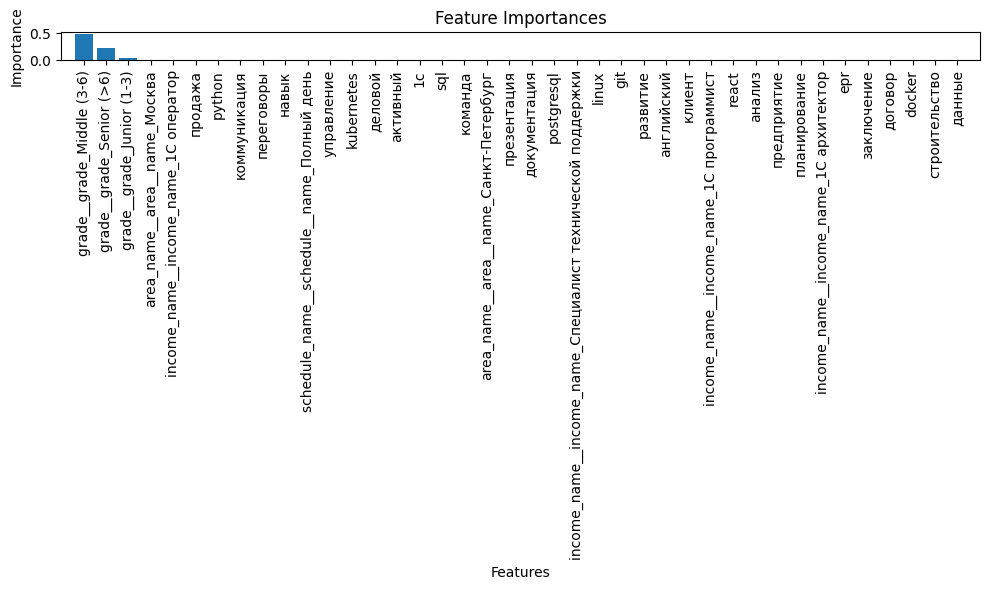

In [31]:
train(df_after_preprocess, RandomForestRegressor(n_jobs=-1, random_state=RANDOM_STATE))